## Import packages

In [1]:
import numpy as np
import xarray as xr
%matplotlib inline
import matplotlib.pyplot as plt
import json
from sklearn.linear_model import LinearRegression as LiRe

# load model data

In [2]:
DETREND='detrend_L1'
file_name = f'./data/CMIP6_dtas_dR_data.{DETREND}.nc'
data = xr.open_dataset(file_name)
model_num = data.model.shape[0]
model_name = data.model.values

# Effective climate sensitivity (EffCS)


Following Gregory et al. (2004),
$$dR = 2*ERF_{2x} + \lambda \ T $$
$$ECS_{2x} = ERF_{2x} / \lambda $$

In [3]:
## regression: dT and dR
## regression: y-intercept: 2xERF; x-intercept: 2xECS; slope: climate feedback
ERF_4xCO2  = np.zeros((3,model_num))
ECS_4xCO2  = np.zeros((3,model_num))
CLF_4xCO2  = np.zeros((3,model_num))

for i in range(model_num):
    dts_sm         = data.dtas_gm_abrupt_4xCO2[i,:].values.reshape((-1, 1))
    dR_gm_4xCO2    = data.dR_gm_abrupt_4xCO2[i,:].values
    single_fit_tmp = LiRe().fit(dts_sm[:], dR_gm_4xCO2)
    ERF_4xCO2[0,i]   = single_fit_tmp.intercept_ / 2
    CLF_4xCO2[0,i]   = single_fit_tmp.coef_ 
    ECS_4xCO2[0,i]   = - ERF_4xCO2[0,i] / single_fit_tmp.coef_ 
    single_fit_tmp = LiRe().fit(dts_sm[:25], dR_gm_4xCO2[:25])
    ERF_4xCO2[1,i]   = single_fit_tmp.intercept_ / 2
    CLF_4xCO2[1,i]   = single_fit_tmp.coef_ 
    ECS_4xCO2[1,i]   = - ERF_4xCO2[1,i] / single_fit_tmp.coef_ 
    single_fit_tmp = LiRe().fit(dts_sm[25:], dR_gm_4xCO2[25:])
    ERF_4xCO2[2,i]   = single_fit_tmp.intercept_ / 2
    CLF_4xCO2[2,i]   = single_fit_tmp.coef_ 
    ECS_4xCO2[2,i]   = - ERF_4xCO2[2,i] / single_fit_tmp.coef_
    

maximum diff of ECS: 1.565


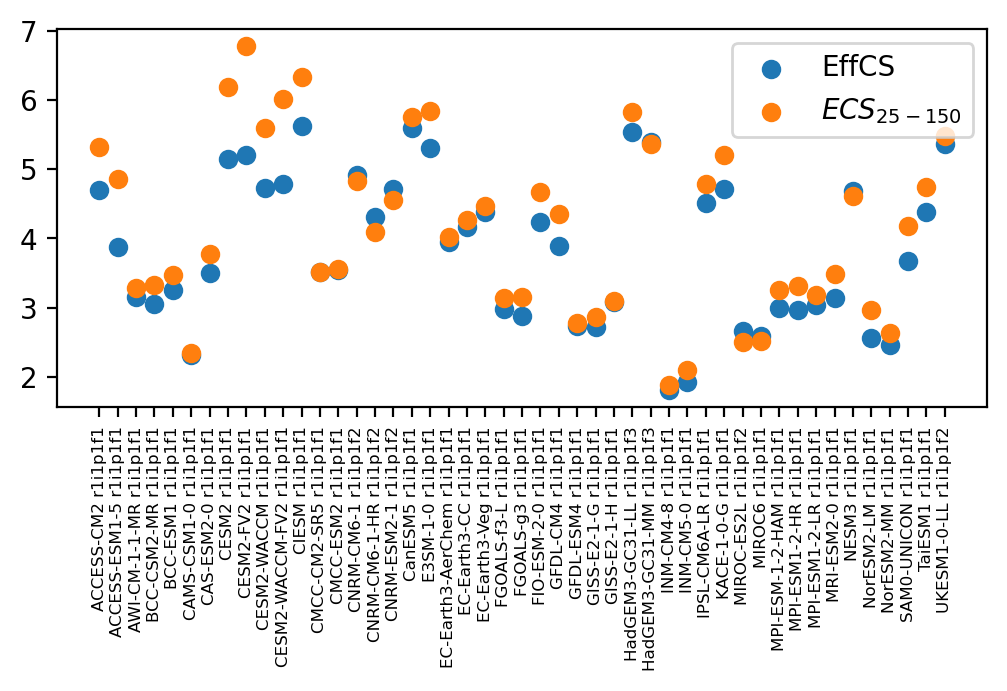

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,2.5),dpi=200) 
axs.scatter(np.arange(model_num),ECS_4xCO2[0,:],label='EffCS')
axs.scatter(np.arange(model_num),ECS_4xCO2[2,:],label=r'$ECS_{25-150}$')
axs.set_xticks(np.arange(model_num))
axs.set_xticklabels(list(model_name),fontdict={'fontsize':6})
plt.xticks(rotation=90)
axs.legend()
print(f'maximum diff of ECS: {np.max(np.abs(ECS_4xCO2[0]-ECS_4xCO2[2])):5.3f}')

# TCR

In [5]:
dtas_gm_1pct  = data.dtas_gm_1pctCO2
## regression: TCR = dT[60-80]
TCR    = np.empty((2,model_num))

for i in range(model_num):
    dts_sm   = dtas_gm_1pct[i,60:80].mean()
    TCR[0,i] = dts_sm
    dts_sm   = dtas_gm_1pct[i,130:150].mean()
    TCR[1,i] = dts_sm
    

maximum diff of TCR: 0.822


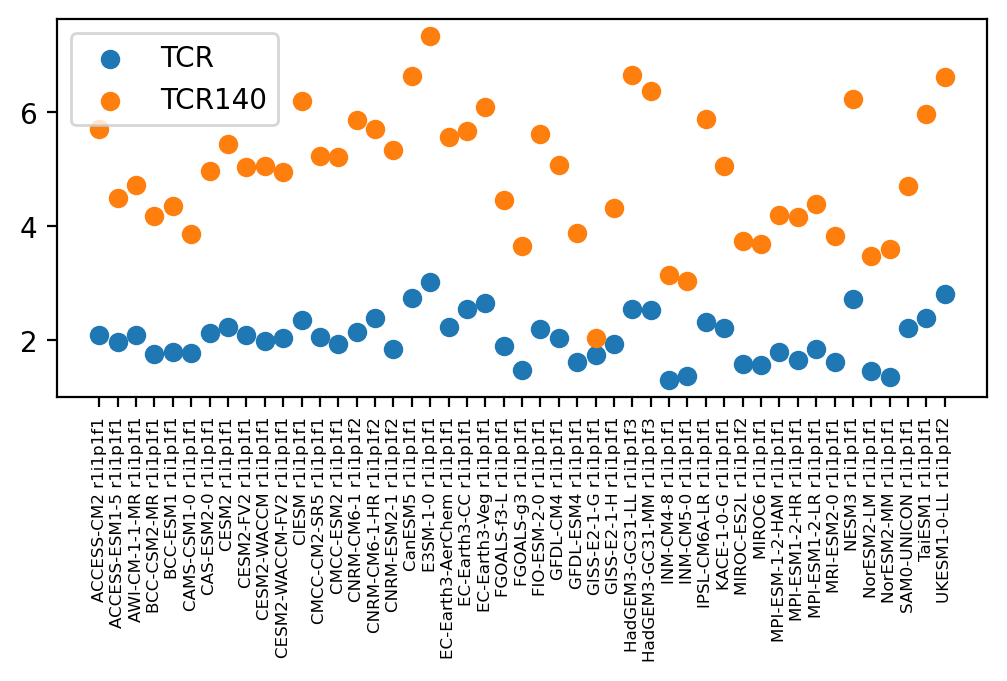

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,2.5),dpi=200) 
axs.scatter(np.arange(model_num),TCR[0,:].T,label='TCR')
axs.scatter(np.arange(model_num),TCR[1,:].T,label='TCR140')

axs.set_xticks(np.arange(model_num))
axs.set_xticklabels(list(model_name),fontdict={'fontsize':6})
plt.xticks(rotation=90)
axs.legend()
print(f'maximum diff of TCR: {np.max(np.abs(TCR[0]-TCR[1]/2)):5.3f}')

# SAVE Results

In [7]:
data = {}
for i,model in enumerate(model_name):
    data[model] = {}
    data[model]['EffCS']    = ECS_4xCO2[0,i]  
    data[model]['CLF'] = CLF_4xCO2[0,i]
    data[model]['ECS'] = ECS_4xCO2[2,i]
    data[model]['TCR']    = TCR[0,i]
    if model == 'GISS-E2-1-G r1i1p1f1': continue # only run to 2xCO2
    data[model]['TCR140'] = TCR[1,i]

In [8]:

file_json=f'ECS_EffCS_TCR_TCR140_{DETREND}.json'
with open(file_json,'w') as tjson:
    json.dump(data, tjson,sort_keys=True, indent=4)